# Sentiment Analysis using Keras

Keras is a high-level neural networks API, capable of running on top of Tensorflow, Theano, and CNTK. It enables fast experimentation through a high level, user-friendly, modular and extensible API. Keras can also be run on both CPU and GPU.

    
Keras provides seven different datasets, which can be loaded in using Keras directly. These include image datasets as well as a house price and a movie review datasets. In this notebook, we will use a pre-processed version of IMDB dataset described in the previous sections. 

### Load the data

In [4]:
#download the data
import keras
from keras.datasets import imdb 
top_words = 5000 
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=top_words)

The code above does a couple of things at once:

    It downloads the data
    It downloads the first 5000 top words for each review
    It splits the data into a test and a training set.

In [5]:
print(len(X_train), 'training examples')
print(len(X_train), 'test examples')

print("\nOne example of traning:")
print(X_train[0])

25000 training examples
25000 test examples

One example of traning:
[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 2, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 2, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 2, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 2, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 2, 19, 178, 32]


If you look at the data you will realize it has been already pre-processed. All words have been mapped to integers and the integers represent the words sorted by their frequency. 

Let's see the corresponding text for this example:

In [6]:
#reverse lookup
INDEX_FROM = 3
word_to_id = keras.datasets.imdb.get_word_index()
word_to_id = {k:(v+INDEX_FROM) for k,v in word_to_id.items()}
word_to_id["<PAD>"] = 0
word_to_id["<START>"] = 1
word_to_id["<UNK>"] = 2
id_to_word = {value:key for key,value in word_to_id.items()}
print(' '.join(id_to_word[id] for id in X_train[0] ))

<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly <UNK> was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little <UNK> that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big <UNK> for the whole film but these children are amazing and should be <UNK> for what they

### Preprocess the data

Since the reviews differ heavily in terms of lengths we want to trim each review to its first 500 words. We need to have text samples of the same length in order to feed them into our neural network. If reviews are shorter than 500 words we will pad them with zeros. Keras being super nice, offers a set of preprocessing routines that can do this for us easily. 

In [7]:
# Truncate and pad the review sequences 
from keras.preprocessing import sequence 
max_review_length = 500 
X_train = sequence.pad_sequences(X_train, maxlen=max_review_length) 
X_test = sequence.pad_sequences(X_test, maxlen=max_review_length) 

In [8]:
X_test[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

### Build the model

Surprisingly we are already done with the data preparation and can already start to build our model. 

In [9]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
import numpy as np
# Build the model 
embedding_vector_length = 32 
model = Sequential() 
model.add(Embedding(top_words, embedding_vector_length, input_length=max_review_length)) 
model.add(LSTM(100)) 
model.add(Dense(1, activation='sigmoid')) 
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy']) 
print(model.summary()) 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 32)           160000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 213,301
Trainable params: 213,301
Non-trainable params: 0
_________________________________________________________________
None


### Train the model

To train the model we simply call the fit function,supply it with the training data and also tell it which data it can use for validation. That is really useful because we have everything in one call.

The training of the model might take a while, especially when you are only running it on the CPU instead of the GPU. When the model training happens, what you want to observe is the loss function, it should constantly be going down, this shows that the model is improving. We will make the model see the dataset 3 times, defined by the epochs parameter. The batch size defines how many samples the model will see at once - in our case 64 reviews

In [10]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), nb_epoch=5, batch_size=64) 

/anaconda3/envs/yourika-env/lib/python3.6/site-packages/ipykernel/__main__.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  if __name__ == '__main__':


Train on 3000 samples, validate on 25000 samples
Epoch 1/3
3000/3000 [==============================] - 37s 12ms/step - loss: 0.6858 - acc: 0.5487 - val_loss: 0.6682 - val_acc: 0.6943
Epoch 2/3
3000/3000 [==============================] - 36s 12ms/step - loss: 0.5989 - acc: 0.7307 - val_loss: 0.6085 - val_acc: 0.6668
Epoch 3/3
3000/3000 [==============================] - 40s 13ms/step - loss: 0.4672 - acc: 0.8213 - val_loss: 0.4357 - val_acc: 0.8017


We can visualize our training and testing accuracy and loss for each epoch so we can get intuition about the performance of our model.

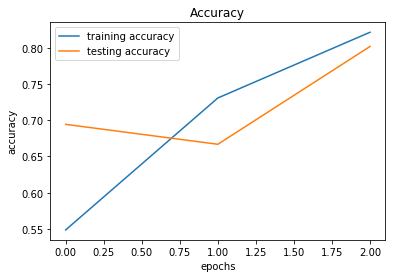

In [11]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'], label='training accuracy')
plt.plot(history.history['val_acc'], label='testing accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

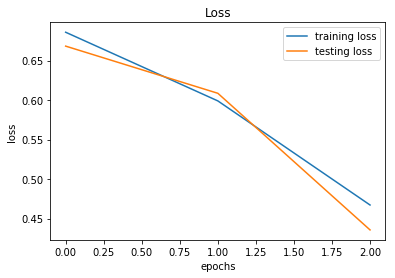

In [12]:
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='testing loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

### Test the model

Once we have finished training the model we can easily test its accuracy. Keras provides a very handy function to do that:

In [34]:
scores = model.evaluate(X_test, y_test, verbose=0) 
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 85.41%


### Prediction

Of course at the end we want to use our model in an application. So we want to use it to create predictions. In order to do so we need to translate our sentence into the corresponding word integers and then pad it to match our data. We can then feed it into our model and see if how it thinks we liked or disliked the movie.

In [36]:
#predict sentiment from reviews
bad = "this movie was terrible and bad"
good = "i really liked the movie and had fun"
for review in [good,bad]:
    tmp = []
    for word in review.split(" "):
        tmp.append(word_to_id[word])
    tmp_padded = sequence.pad_sequences([tmp], maxlen=max_review_length) 
    print("%s. Sentiment: %s" % (review,model.predict(np.array([tmp_padded][0]))[0][0]))

i really liked the movie and had fun. Sentiment: 0.85503125
this movie was terrible and bad. Sentiment: 0.060539983
